In [1]:
from sched import scheduler
import torch
from torch.utils.data import DataLoader
import argparse
from augmentation import BaseAugmentation
from criterion import *
from dataset import UnalignedDataset
from model import *
from utils import *

from scheduler import DelayedLinearDecayLR

from functools import partial
import itertools
import os
from tqdm import tqdm
import wandb

def parse_opt():
    parser = argparse.ArgumentParser()
    
    # miscellaneous arguments for training
    parser.add_argument("--is_train", type=bool, default=True)
    parser.add_argument("--num_threads", type=int, default=24)
    parser.add_argument("--gpu_id", type=int, default=0)
    parser.add_argument("--random_seed", type=int, default=0)

    # image datasets
    parser.add_argument("--data_root_A", type=str, default="../data/Ghibli_Images/ghibli_jpg")
    parser.add_argument("--data_root_B", type=str, default="../data/Ghibli_Images/photo_jpg")

    # training details
    parser.add_argument("--batch_size", type=int, default=1)
    parser.add_argument("--n_epochs", type=int, default=200)
    parser.add_argument("--beta1", type=float, default=.5, help = "beta1 for Adam optimizer")
    parser.add_argument("--lr", type=float, default=.0002)

    # learning rate decay
    parser.add_argument("--decay_after", type=int, default=100)
    parser.add_argument("--target_lr", type=float, default=0.0)
    parser.add_argument("--total_iters", type=int, default=100)
    parser.add_argument("--lr_decay_verbose", type=bool, default=False)

    # hyperparameter in respect to a loss
    parser.add_argument("--lambda_cyc", type=float, default=10.0)
    parser.add_argument("--lambda_idt", type=float, default=0.5)
    
    # wandb & logging
    parser.add_argument("--prj_name", type=str, default="cycle_gan")
    parser.add_argument("--exp_name", type=str, default="exp1")
    parser.add_argument("--log_interval", type=int, default=25)
    parser.add_argument("--sample_save_dir", type=str, default='./test_results/') # only for test.py
    parser.add_argument("--last_checkpoint_dir", type=str, default="./weights/D_averaging")
    parser.add_argument("--checkpoint_dir", type=str, default="./weights")
    parser.add_argument("--load_epoch", type=int, default=150)
    
    # resume from
    parser.add_argument("--resume_from", action="store_true")

    # opt = parser.parse_args()
    # .ipynb ipynbkernel에서는 직접적으로 인수를 넣어줄수 없어 해당 코드로 교체

    opt = parser.parse_args([])

    return opt

opt = parse_opt()
fix_seed(opt.random_seed) # randomness 제어

# wandb logging init
wandb.init(project=opt.prj_name, name=opt.exp_name, entity="eastk1te", config=vars(opt)) # save a configuration of experiments on an wandb session.


os.makedirs(opt.sample_save_dir, exist_ok=True)

# device
device = torch.device(f'cuda:{opt.gpu_id}' if torch.cuda.is_available() else 'cpu')    

# define transforms
transforms = BaseAugmentation()

# load datasets
train_data = UnalignedDataset(opt.data_root_A, opt.data_root_B, opt.is_train, transforms = transforms.transform)
train_loader = DataLoader(train_data, batch_size=opt.batch_size, num_workers=opt.num_threads, shuffle=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eastk1te. Use `wandb login --relogin` to force relogin


/home/my-computer/.virtualenvs/CycleGAN-OJjeCo5F/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 이미지 shape 확인

In [ ]:
len(train_data.image_paths_A), len(train_data.image_paths_B)

(781, 781)

In [2]:
for i in range(len(train_data)):
    print(train_data[i]['A'].size(),train_data[i]['B'].size())

torch.Size([3, 162, 300]) torch.Size([3, 180, 320])
torch.Size([3, 162, 300]) torch.Size([3, 320, 320])
torch.Size([3, 162, 300]) torch.Size([3, 213, 319])
torch.Size([3, 162, 300]) torch.Size([3, 240, 320])
torch.Size([3, 162, 300]) torch.Size([3, 320, 200])
torch.Size([3, 162, 300]) torch.Size([3, 319, 261])
torch.Size([3, 162, 300]) torch.Size([3, 320, 240])
torch.Size([3, 162, 300]) torch.Size([3, 320, 320])
torch.Size([3, 162, 300]) torch.Size([3, 320, 320])
torch.Size([3, 162, 300]) torch.Size([3, 320, 240])
torch.Size([3, 162, 300]) torch.Size([3, 240, 320])
torch.Size([3, 162, 300]) torch.Size([3, 240, 320])
torch.Size([3, 162, 300]) torch.Size([3, 320, 241])
torch.Size([3, 162, 300]) torch.Size([3, 320, 240])
torch.Size([3, 162, 300]) torch.Size([3, 320, 249])
torch.Size([3, 162, 300]) torch.Size([3, 167, 320])
torch.Size([3, 162, 300]) torch.Size([3, 240, 320])
torch.Size([3, 162, 300]) torch.Size([3, 213, 319])
torch.Size([3, 162, 300]) torch.Size([3, 319, 213])
torch.Size([

In [ ]:
# 이미지 확인결과 지브리 이미지파일은 torch.Size([3, 162, 300])로 일정, 그러나 일반 photo 이미지는 각기 다양함.

In [ ]:
A_min_size, B_min_size = torch.Size([99,99,99]),torch.Size([99,99,99])
for i in range(len(train_data)):
    if A_min_size > train_data[i]['A'].size():
        A_min_size = train_data[i]['A'].size()
    if B_min_size > train_data[i]['B'].size():
        B_min_size = train_data[i]['B'].size()
print(A_min_size, B_min_size)

torch.Size([3, 162, 300]) torch.Size([3, 134, 320])


In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())

1
0


In [ ]:
opt.gpu_id

0

In [4]:
# load model
G = Generator().to(device)
F = Generator().to(device)
D_x = Discriminator().to(device)
D_y = Discriminator().to(device)

In [5]:
# define optimizer
optimizer = partial(torch.optim.Adam, lr=opt.lr, betas=(opt.beta1, 0.999))

optim_G = optimizer(params = itertools.chain(G.parameters(), F.parameters()))
optim_D = optimizer(params = itertools.chain(D_x.parameters(), D_y.parameters()))

# scheduler
scheduler_G = DelayedLinearDecayLR(optim_G, opt.lr, opt.target_lr, opt.total_iters, decay_after=opt.decay_after, verbose=opt.lr_decay_verbose)
scheduler_D = DelayedLinearDecayLR(optim_D, opt.lr, opt.target_lr, opt.total_iters, decay_after=opt.decay_after, verbose=opt.lr_decay_verbose)


criterion_G = AdversarialLoss()
criterion_D = AdversarialLoss()
criterion_cyc = CycleConsistencyLoss()
criterion_idt = IdentityLoss()

G.train()
F.train()
D_x.train()
D_y.train()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [6]:
if opt.resume_from:
    checkpoint_path = os.path.join(opt.last_checkpoint_dir, f"epoch{opt.load_epoch}.pth")
    if "LinearDecay" in getattr(type(scheduler_D), '__name__'): # when using LinearDecayLR, not loading state dict for optimizers and schedulers.
        G, F, D_x, D_y, start_epoch = load_checkpoint(checkpoint_path, G, F, D_x, D_y)
        # decay after 같은 부분 수정하는 건 그냥 config 자체에서 받아오는 걸로 / last epoch만 수정해주자.
        scheduler_dict = {
            'decay_after': start_epoch + opt.decay_after,
            'last_epoch': opt.load_epoch
        }
        scheduler_G.load_state_dict(scheduler_dict)
        scheduler_D.load_state_dict(scheduler_dict)

    else:
        G, F, D_x, D_y, optim_G, optim_D, scheduler_G, scheduler_D, start_epoch = load_checkpoint(checkpoint_path, G, F, D_x, D_y, \
                                                                                                optim_G, optim_D, scheduler_G, scheduler_D, mode="all")
    start_epoch += 1
else: # not_resume from
    start_epoch = 0

In [ ]:
d_f_y.shape

torch.Size([1, 1, 25, 38])

In [ ]:
Y.shape, X.shape

(torch.Size([1, 3, 213, 319]), torch.Size([1, 3, 162, 300]))

In [ ]:
rec_x.shape, rec_y.shape

(torch.Size([1, 3, 164, 300]), torch.Size([1, 3, 216, 320]))

In [ ]:
d_g_x.shape, real_label.shape
d_f_y.shape, real_label.shape

(torch.Size([1, 1, 25, 38]), torch.Size([1, 1, 18, 35]))

In [9]:
data['A'].shape, data['B'].shape

(torch.Size([1, 3, 162, 300]), torch.Size([1, 3, 213, 319]))

In [120]:
import torch
import torch.nn as nn

class ImageResizer(nn.Module):
    def __init__(self, target_size):
        super(ImageResizer, self).__init__()
        self.target_size = target_size

    def forward(self, x):
        # x: 입력 이미지 (batch_size, channels, height, width)
        resized = torch.nn.functional.interpolate(x, size=self.target_size, mode='bilinear', align_corners=False)
        return resized
# ImageResizer 인스턴스 생성
resizer = ImageResizer(target_size=(164,300))

In [119]:
train_data[0]['A'].size()[1:]

torch.Size([162, 300])

In [ ]:
for epoch in range(start_epoch, start_epoch+opt.n_epochs):
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, data in pbar:
        
        # Initialize the gradient stored in the optimizer to zero in the beginning of each step.
        optim_G.zero_grad()
        optim_D.zero_grad()

        # load data on gpu
        X, Y = resizer(data['A']).to(device), resizer(data['B']).to(device)

        #### Generator ####
        for p_x, p_y in zip(D_x.parameters(), D_y.parameters()): # when optimizing G, freeze the parameters regarding D.
            p_x.requires_grad = False
            p_y.requires_grad = False

        # generation & reconstruction
        g_x = G(X) # fake_B
        f_y = F(Y) # fake_A
        rec_x = F(g_x) # rec_A (reconstruction)
        rec_y = G(f_y) # rec_B
        
        # discriminating the generators' outputs.
        d_g_x = D_y(g_x)
        d_f_y = D_x(f_y)

        # generate the label
        real_label = torch.tensor([1.0]).expand_as(d_g_x).to(device)
        fake_label = torch.tensor([0.0]).expand_as(d_f_y).to(device)

        # calculate an adversarial loss -> maximize the probability of the fake to be "considered" real
        loss_G_xy = criterion_G.forward_G(d_g_x, real_label)
        loss_F_yx = criterion_G.forward_G(d_f_y, real_label)

        # calc cycle loss
        loss_cyc = criterion_cyc(X, Y, rec_x, rec_y)

        # calc identity loss if lambda of identity loss larger than zero.
        if opt.lambda_idt > 0:
            loss_idt = opt.lambda_idt*criterion_idt(X, Y, f_y, g_x)
        else: # lambda_idt = 0
            loss_idt = 0

        loss_G = loss_G_xy + loss_F_yx + opt.lambda_cyc*loss_cyc + opt.lambda_idt*loss_idt
        
        loss_G.backward() # calculate all the gradient with respect to loss_G.
        optim_G.step() # alternating training 해야돼서 G랑 D는 optimizer 따로 쓰는 거임.

        #### Discriminator ####
        for p_x, p_y in zip(D_x.parameters(), D_y.parameters()):
            p_x.requires_grad = True
            p_y.requires_grad = True

        loss_D_xy = criterion_D.forward_D(D_y(Y), real_label, D_y(g_x.detach()), fake_label)
        loss_D_yx = criterion_D.forward_D(D_x(X), real_label, D_x(f_y.detach()), fake_label)
        
        # average the loss
        loss_D = (loss_D_xy+loss_D_yx)/2

        loss_D.backward()
        optim_D.step()

        # logging
        description = f'Epoch: {epoch+1}/{start_epoch+opt.n_epochs} || Step: {step+1}/{len(train_loader)} || Generator Loss: {round(loss_G.item(), 4)} \
                        || Discriminator Loss (XY, YX): {round(loss_D_xy.item(), 4)},{round(loss_D_yx.item(), 4)}'
        pbar.set_description(description)
        
        # wandb logging if log_interval is greater than zero.
        if (opt.log_interval > 0) and ((step+1) % opt.log_interval) == 0:
            wandb.log(
                {
                    "Loss_G(X to Y)": round(loss_G_xy.item(), 4),
                    "Loss_F(Y to X)": round(loss_F_yx.item(), 4),
                    "Cycle Consistency Loss": round(loss_cyc.item(), 4),
                    "Loss_D(X to Y)": round(loss_D_xy.item(), 4),
                    "Loss_D(Y to X)": round(loss_D_yx.item(), 4)
                }
            )
            
            # If identity loss is valid, log the identity loss as well.
            if opt.lambda_idt:
                wandb.log({"Identity Loss": round(loss_idt.item(), 4)})

    # Apply the scheduler (make sure the step of optimizers precede that of schedulers)
    scheduler_G.step()
    scheduler_D.step()

    # saving sample outputs
    if opt.log_interval > 0: # if use wandb
        wandb.log(
            {
                "X": wandb.Image(denormalize_image(X.clone().detach().cpu())),
                "Y": wandb.Image(denormalize_image(Y.clone().detach().cpu())),
                "Generated Target (X->Y)": wandb.Image(denormalize_image(g_x.clone().detach().cpu())), # G(X)
                "Reconstructed Target (Y->X->Y)": wandb.Image(denormalize_image(rec_y.clone().detach().cpu())),
                "Generated Input (Y->X)": wandb.Image(denormalize_image(f_y.clone().detach().cpu())), # F(Y)
                "Reconstructed Input (X->Y->X)": wandb.Image(denormalize_image(rec_x.clone().detach().cpu()))
            }
        )
    
    else:
        save_image(g_x.clone().detach().cpu(), f"{opt.sample_save_dir}/epoch{epoch+1}.png")

    # saving checkpoints
    checkpoint_dir = os.path.join(opt.checkpoint_dir, opt.exp_name)
    save_checkpoint(epoch, G, F, D_x, D_y, optim_G, optim_D, scheduler_G, scheduler_D, checkpoint_dir, file_name=f"epoch{epoch+1}.pth")

In [118]:
X.shape, Y.shape, g_x.shape, f_y.shape, rec_x.shape, rec_y.shape, 

(torch.Size([1, 3, 162, 300]),
 torch.Size([1, 3, 162, 300]),
 torch.Size([1, 3, 164, 300]),
 torch.Size([1, 3, 164, 300]),
 torch.Size([1, 3, 164, 300]),
 torch.Size([1, 3, 164, 300]))

In [57]:
def channel_change(img):
    return img

(162, 300, 3)


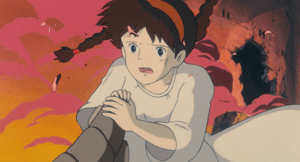

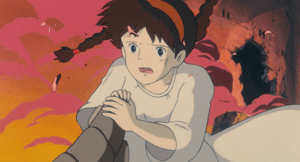

In [106]:
import glob
from torchvision.transforms import ToPILImage
from IPython.display import display

tf = ToPILImage()
img_dir = "../data/Ghibli_Images/ghibli_jpg"
img_dir = glob.glob(img_dir+"/*")
img = cv2.imread(img_dir[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape) # 이미지가 다 scale되어있음을 확인.
display(tf(img))
display(tf(torch.tensor(img).permute(2, 0, 1)))

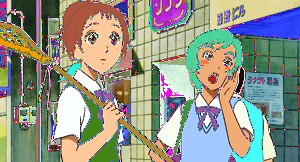

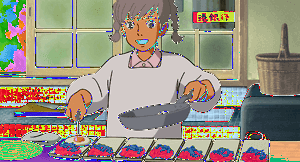

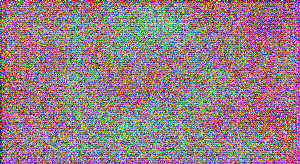

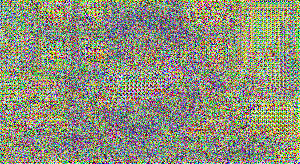

In [115]:
# dataloader할때 정규화 진행해서 원본하고 다름.
display(tf(train_data[0]['A']))
display(tf(X[0]))
display(tf(rec_x[0]))
display(tf(g_x[0]))